Compare nominal MC distributions with the observed data.

In [1]:
import yoda
from __future__ import print_function
from future.utils import iteritems
from future.utils import itervalues
from future.utils import iterkeys

import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
input_dir = 'SamplesWithTunedParameters'

In [3]:
processes = [
    ['Wmunu',  '50k'],
    ['Wenu',   '50k'],
    ['Wtaunu', '50k'],
    ['Zmumu',  '50k'],
    ['Ztautau', '50k'],
    ['Zvv', '50k'],
    ['ttbar', '1M'],
    ['vv', '1M']
]
samples = [x[0] for x in processes]
print(samples)
analysis = 'ATLAS_2017_I1635274'

['Wmunu', 'Wenu', 'Wtaunu', 'Zmumu', 'Ztautau', 'Zvv', 'ttbar', 'vv']


In [11]:
def make_ploter(input_dir_, samples, analysis):
    # read yoda files
    input_dir = os.path.join('inputs', input_dir_)
    data_dict = {}
    for sample in samples:
        file_name = os.path.join(input_dir, sample, 'submit', '000001', 'combined.yoda')
        data = yoda.read(file_name)
        data_dict[sample] = data
        
    data_name = analysis+'.yoda'
    ref_data = yoda.read(os.path.join(input_dir, data_name))
    tuned_data = yoda.read(os.path.join(input_dir, 'ipolhistos.yoda'))
    
    # define some ploting styles
    COLORS = ["steelblue", "darkorange", "forestgreen", "firebrick", "darkviolet", "saddlebrown", "plum", 'darkgrey']
    LSTYLES = ['solid']*10
    
    plotkeys = {
        "xlabel": "",
        "ylabel": "Events / Bin",
        "logY": True,
        "title": r"new physics search in mono-jet channel",
        'LegendFontSize': 'large',
        "ratioymin": 0.8,
        "ratioymax": 1.2,
        'ratiogrid': False
    }
    
    def ploter(name, xaxis_label=" ", logY=False, out_file_name='test', y_limis=(1e-3, 1e4)):
        hist_name = '/'+analysis+'/'+name

        results = []
        #sort samples according to their area
        sorted_samples = []
        print(name)
        for ip,sample in enumerate(samples):
            hist = data_dict[sample][hist_name]
            
            hist.setAnnotation('linecolor', COLORS[ip])
            hist.setAnnotation('linestyle', LSTYLES[ip])
            hist.setAnnotation('Title', sample)
            hist.setAnnotation('line', 'bar')
            print(sample,"yields:", hist.integral())
            #results.append(sample)
            results.append(hist.integral())

            if hist.integral() < 1e-5:
                continue
            else:
                pass
                
            if len(sorted_samples) == 0:
                sorted_samples.append(sample)
            else:
                #temp_samples = sorted_samples
                for ipushed, pushed in enumerate(sorted_samples):
                        
                    ipushed_hist = data_dict[pushed][hist_name]
                    if hist.integral() <= ipushed_hist.integral():
                        # print(sample," will be inserted to ", ipushed)
                        sorted_samples.insert(ipushed, sample)
                        break
                    elif ipushed == len(sorted_samples) - 1:
                        sorted_samples.append(sample)
                        break
                    else:
                        pass
                    
        
        # print(name, "selected samples: ", ",".join(sorted_samples))
        stacked_plots = []
        for ip,sample in enumerate(sorted_samples):
            hist = data_dict[sample][hist_name].clone()
            hist.setAnnotation('nEvents', hist.integral())
            next_ip = ip - 1
            while next_ip >= 0:
                hist += data_dict[sorted_samples[next_ip]][hist_name]
                next_ip -= 1

            # hist.setAnnotation('Path', hist.annotation('Path')+"_"+sample)
            stacked_plots.insert(0, hist)
                
        print("Total:", stacked_plots[0].integral())
        results.append(stacked_plots[0].integral())
    
        ref_hist = ref_data["/REF"+hist_name]
        ref_hist.setAnnotation("ratioref", True)
        ref_hist.setAnnotation('linecolor', 'black')
        ref_hist.setAnnotation('line', None)
        ref_hist.setAnnotation('errorbars', True)
        ref_hist.setAnnotation('errorbarscolor', 'black')
        ref_hist.setAnnotation('Title', "Ref. Data")
        ref_sum = sum([p.y*(p.xMax-p.xMin) for p in ref_hist.points])
        ref_hist.setAnnotation("nEvents", ref_sum)
        stacked_plots.insert(0, ref_hist)
        
            
        print("Data:", ref_sum)
        print("--------------------")
        results.append(ref_sum)

        
        plotkeys['xlabel'] = xaxis_label
        plotkeys['logY'] = logY
        plotkeys['ymin'] = y_limis[0]
        plotkeys['ymax'] = y_limis[1]
        
        out = os.path.join('output', input_dir_, "nominal_vs_obs_stack")
        if not os.path.exists(out):
            os.makedirs(out)
        out = os.path.join(out, out_file_name+'.pdf')

        fig, (axmain, axratio) = yoda.plot(stacked_plots, 
                                           outfile=out, ratio=False, **plotkeys)
        return results
    
    return ploter

In [5]:
xaxis_renames = {
    'd01-x01-y01': ['$W \\rightarrow \\mu\\nu$, $E_{T}^{miss}$ [GeV]', True, 'wmunu_met'],
    'd02-x01-y01': ['$W \\rightarrow \\mu\\nu$, leading jet $pT$ [GeV]', True, 'wmunu_pT'],
    'd03-x01-y01': ['$W \\rightarrow e\\nu$, $E_{T}^{miss}$ [GeV]', True, 'wenu_met'],
    'd04-x01-y01': ['$W \\rightarrow e\\nu$, leading jet $pT$ [GeV]', True, 'wenu_pT'],
    'd05-x01-y01': ['$Z \\rightarrow \\mu\\mu$, $E_{T}^{miss}$ [GeV]', True, 'Zmumu_met'],
    'd06-x01-y01': ['$Z \\rightarrow \\mu\\mu$, leading jet $pT$ [GeV]', True, 'Zmumu_pT'],
    'd07-x01-y01': ['ttbar, $E_{T}^{miss}$ [GeV]', True, 'ttbar_met'],
    'd08-x01-y01': ['ttbar, leading jet $pT$ [GeV]', True, 'ttbar_pT'],
    'd09-x01-y01': ['$E_{T}^{miss}$ [GeV]', True, 'sr_met'],
    'd10-x01-y01': ['leading jet $pT$ [GeV]', True, 'sr_pT'],
    'd11-x01-y01': ['leading jet $\\eta$ [GeV]', False, 'sr_eta'],
    'd12-x01-y01': ['$n_{jets}$ [GeV]', False, 'sr_njets']
}

In [12]:
pp = make_ploter(input_dir, samples, analysis)

d01-x01-y01
Wmunu yields: 85806.37
Wenu yields: 0.0
Wtaunu yields: 6423.05
Zmumu yields: 1035.621
Ztautau yields: 129.2795
Zvv yields: 76.70786
ttbar yields: 1305.271
vv yields: 1188.718
Total: 95965.01736
Data: 110938.0
--------------------
d03-x01-y01
Wmunu yields: 0.4059529
Wenu yields: 52699.2
Wtaunu yields: 4509.702
Zmumu yields: 0.0
Ztautau yields: 127.3529
Zvv yields: 6.62025
ttbar yields: 5322.674
vv yields: 750.0242
Total: 63415.9793029
Data: 68974.0
--------------------
d05-x01-y01
Wmunu yields: 266.5315
Wenu yields: 0.0
Wtaunu yields: 69.90351
Zmumu yields: 13111.76
Ztautau yields: 21.16094
Zvv yields: 0.0
ttbar yields: 752.2855
vv yields: 230.8988
Total: 14452.54025
Data: 17372.0
--------------------
d07-x01-y01
Wmunu yields: 1961.912
Wenu yields: 0.0
Wtaunu yields: 136.2229
Zmumu yields: 44.47897
Ztautau yields: 8.925679
Zvv yields: 84.1128
ttbar yields: 4996.284
vv yields: 90.02244
Total: 7321.958789
Data: 9729.0
--------------------
d09-x01-y01
Wmunu yields: 10119.85
Wen

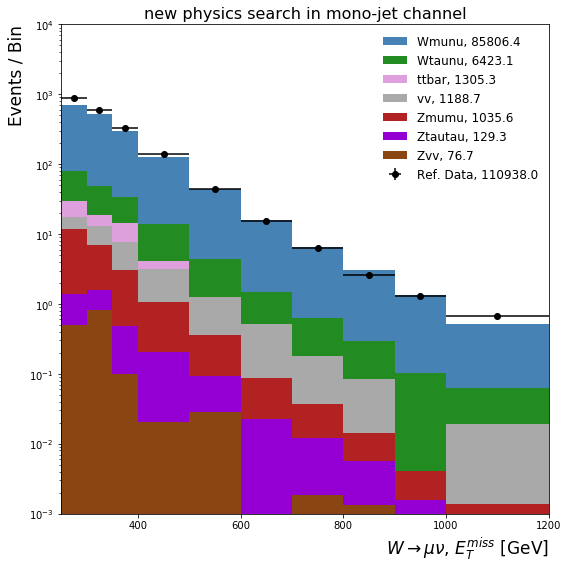

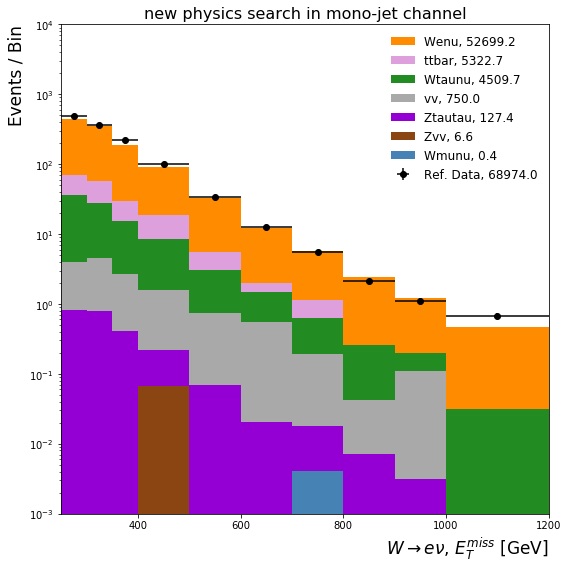

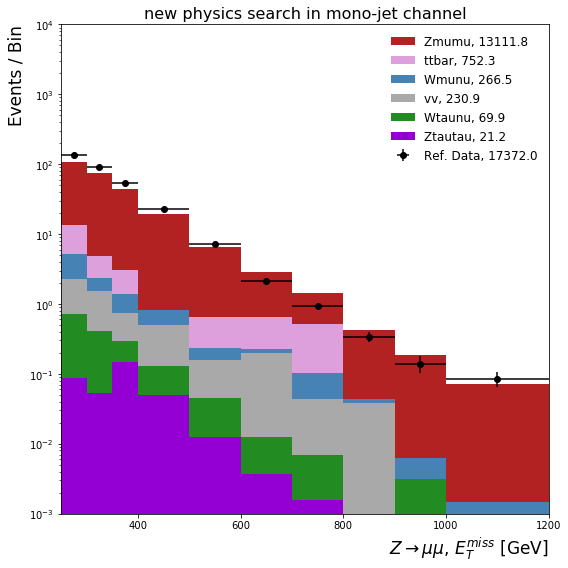

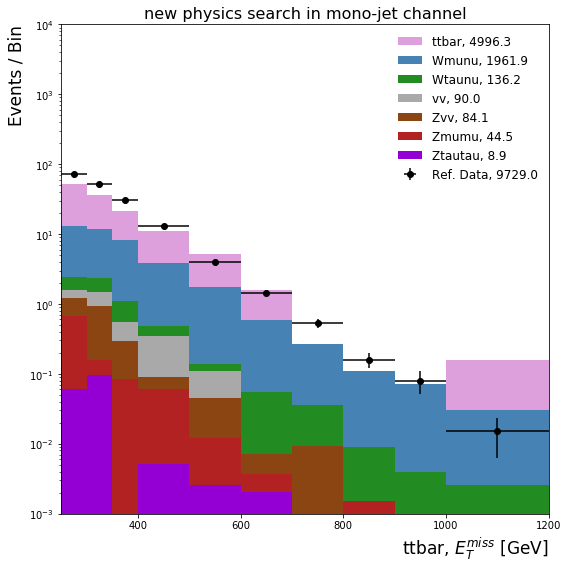

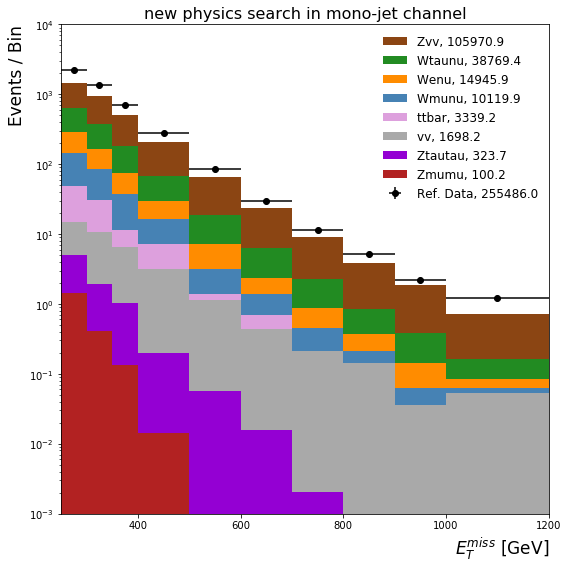

In [19]:
all_results = []
for name in ['d01-x01-y01', 'd03-x01-y01', 'd05-x01-y01', 'd07-x01-y01', 'd09-x01-y01',]:
    logY = xaxis_renames[name][1]
    if logY:
        res = pp(name, *(xaxis_renames[name]))
    elif "d12" in name:
        res = pp(name, *(xaxis_renames[name]), y_limis=(0, 1.4e5))
    elif "d11" in name:
        res = pp(name, *(xaxis_renames[name]), y_limis=(0, 2e5))
    else:
        res = pp(name, *(xaxis_renames[name]), y_limis=(0, 4000))
    
    all_results.append(res)

In [20]:
orders = [4, 0, 2, 1, 3]
out = ""
for ip,sample in enumerate(samples):
    for order in orders:
        res = all_results[order][ip]
        out += str(res) + " "
    out += '\n'

In [21]:
print(out)

10119.85 85806.37 266.5315 0.4059529 1961.912 
14945.94 0.0 0.0 52699.2 0.0 
38769.36 6423.05 69.90351 4509.702 136.2229 
100.198 1035.621 13111.76 0.0 44.47897 
323.7025 129.2795 21.16094 127.3529 8.925679 
105970.9 76.70786 0.0 6.62025 84.1128 
3339.225 1305.271 752.2855 5322.674 4996.284 
1698.168 1188.718 230.8988 750.0242 90.02244 



d12-x01-y01
Wmunu yields: 10119.85
Wenu yields: 14945.94
Wtaunu yields: 38769.36
Zmumu yields: 100.198
Ztautau yields: 323.7025
Zvv yields: 105970.9
ttbar yields: 3339.225
vv yields: 1698.168
Total: 175267.3435
Data: 255486.0
--------------------
d01-x01-y01
Wmunu yields: 85806.37
Wenu yields: 0.0
Wtaunu yields: 6423.05
Zmumu yields: 1035.621
Ztautau yields: 129.2795
Zvv yields: 76.70786
ttbar yields: 1305.271
vv yields: 1188.718
Total: 95965.01736
Data: 110938.0
--------------------
d07-x01-y01
Wmunu yields: 1961.912
Wenu yields: 0.0
Wtaunu yields: 136.2229
Zmumu yields: 44.47897
Ztautau yields: 8.925679
Zvv yields: 84.1128
ttbar yields: 4996.284
vv yields: 90.02244
Total: 7321.958789
Data: 9729.0
--------------------
d02-x01-y01
Wmunu yields: 85806.37
Wenu yields: 0.0
Wtaunu yields: 6423.05
Zmumu yields: 1035.621
Ztautau yields: 129.2795
Zvv yields: 76.70786
ttbar yields: 1305.271
vv yields: 1188.718
Total: 95965.01736
Data: 110938.0
--------------------
d11-x01-y01
Wmunu yields: 101

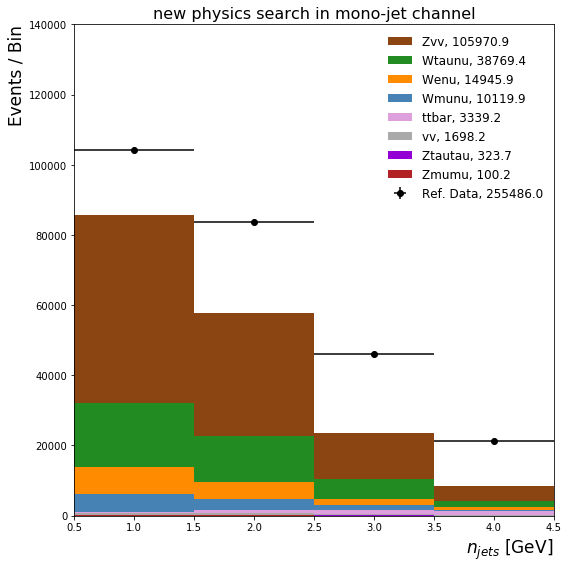

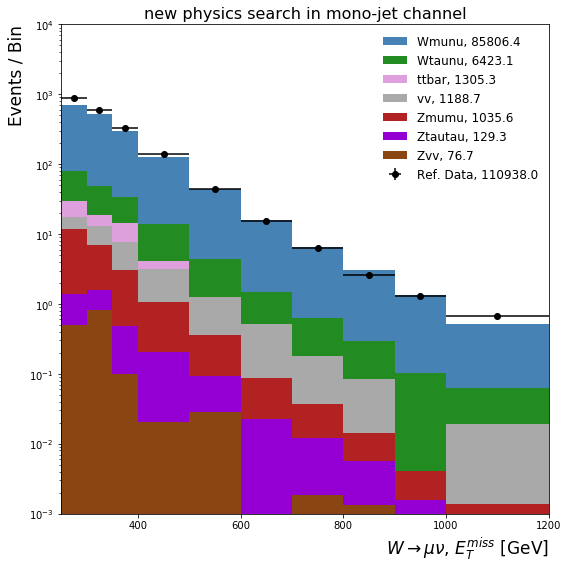

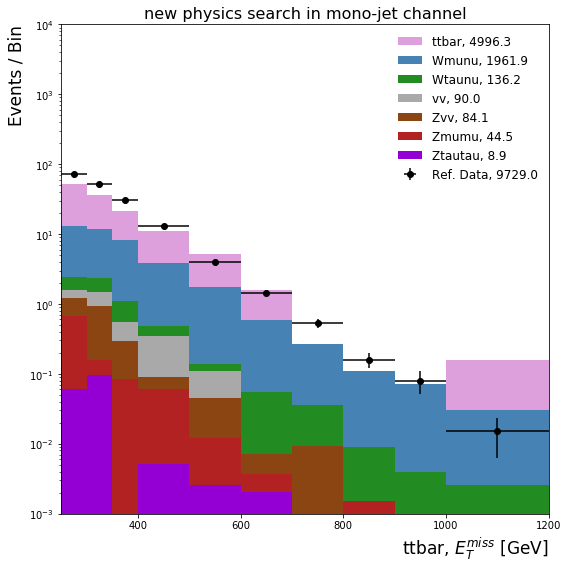

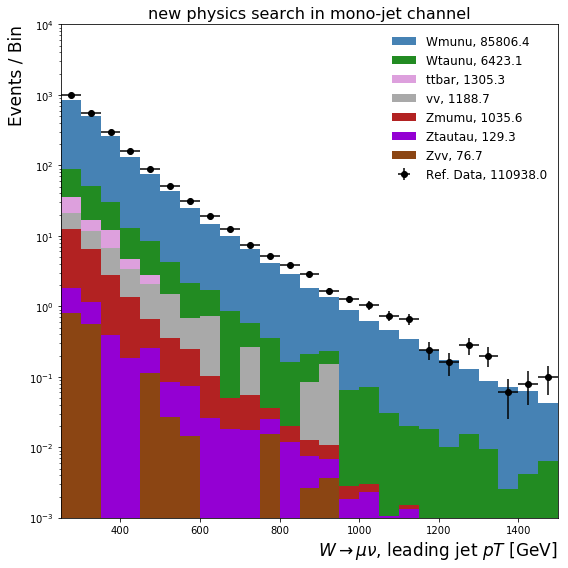

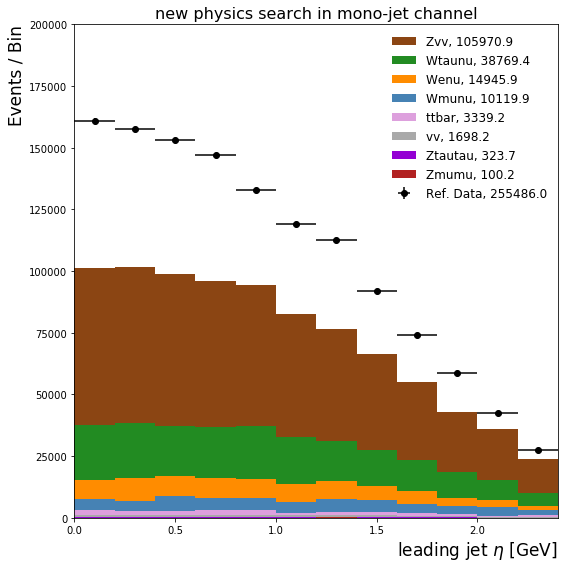

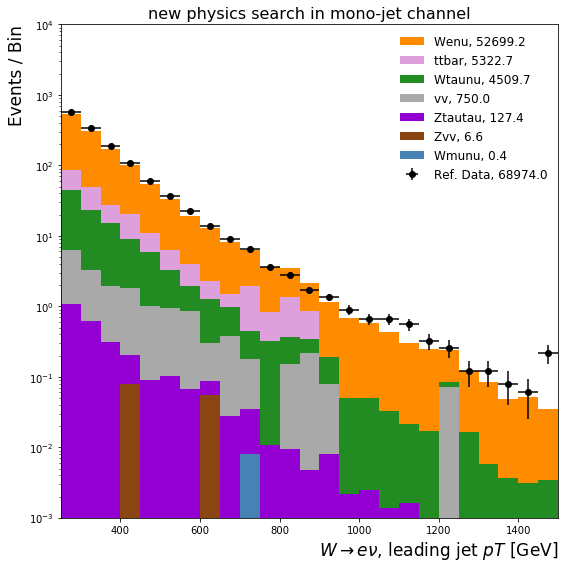

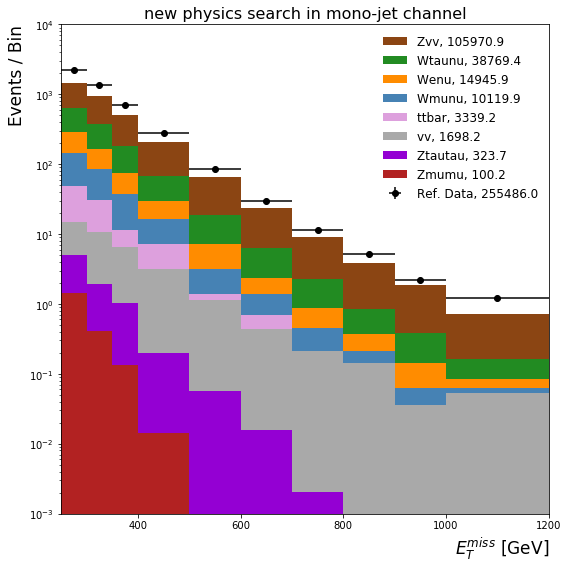

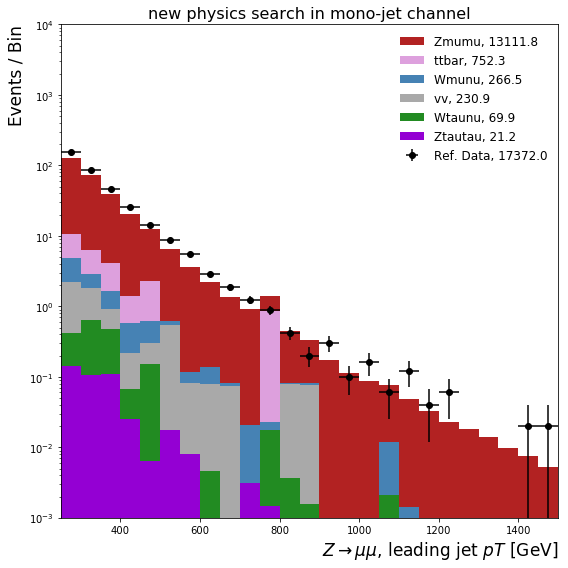

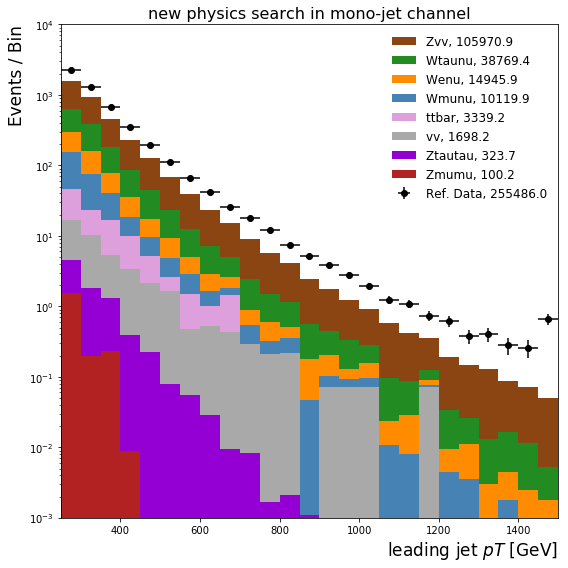

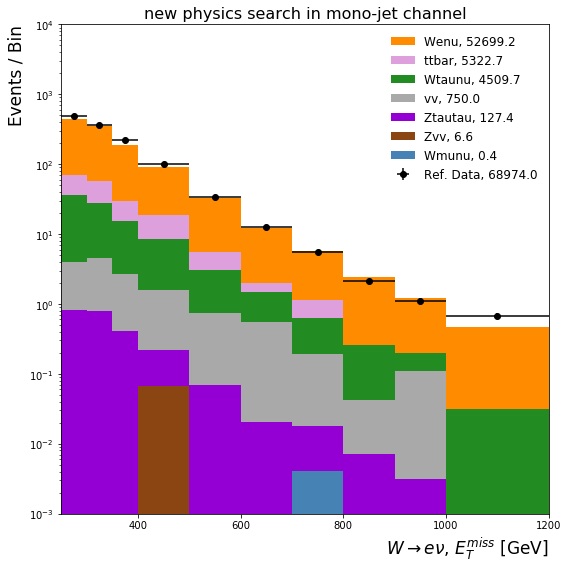

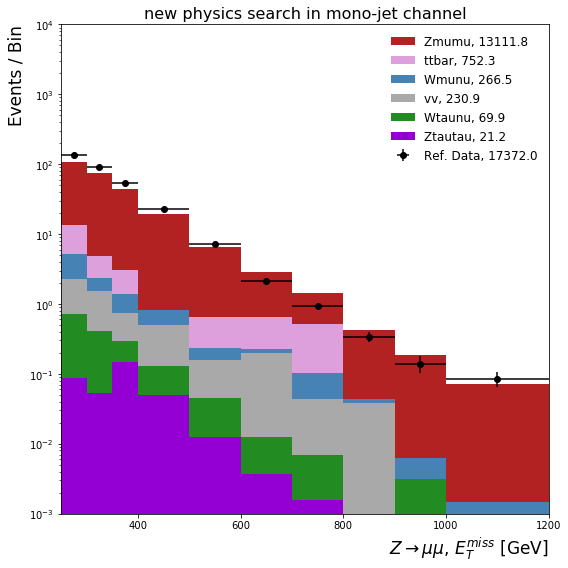

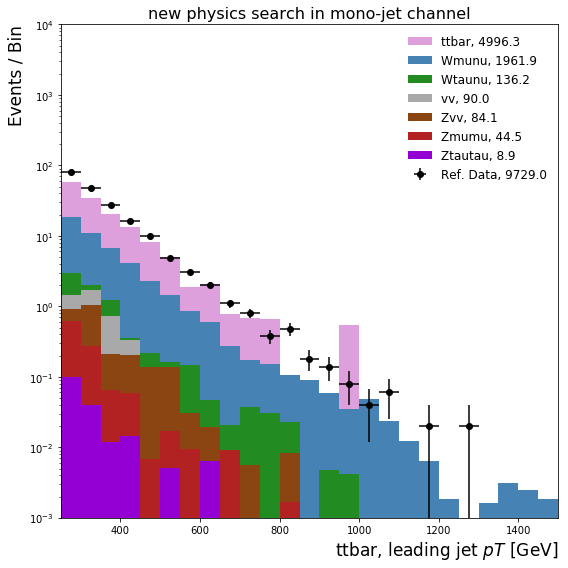

In [6]:
pp = make_ploter(input_dir, samples, analysis)
for name in iterkeys(xaxis_renames):
    logY = xaxis_renames[name][1]
    if logY:
        pp(name, *(xaxis_renames[name]))
    elif "d12" in name:
        pp(name, *(xaxis_renames[name]), y_limis=(0, 1.4e5))
    elif "d11" in name:
        pp(name, *(xaxis_renames[name]), y_limis=(0, 2e5))
    else:
        pp(name, *(xaxis_renames[name]), y_limis=(0, 4000))

In [50]:
pp_stack = make_ploter(input_dir, samples, analysis)

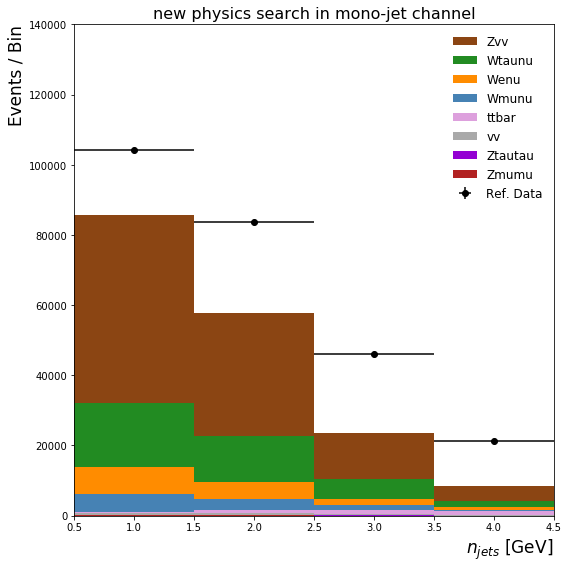

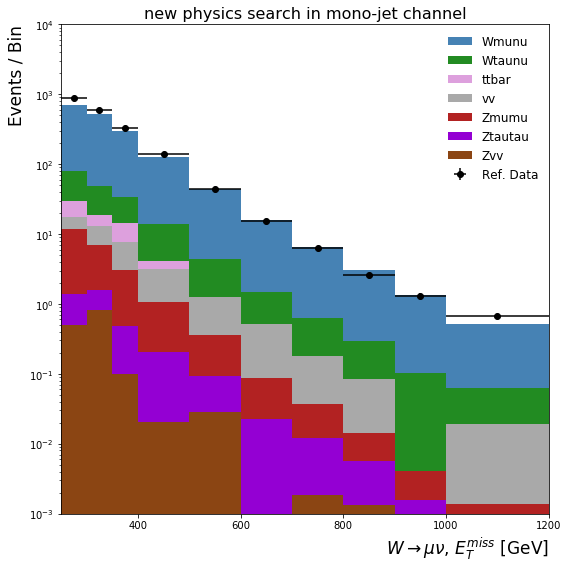

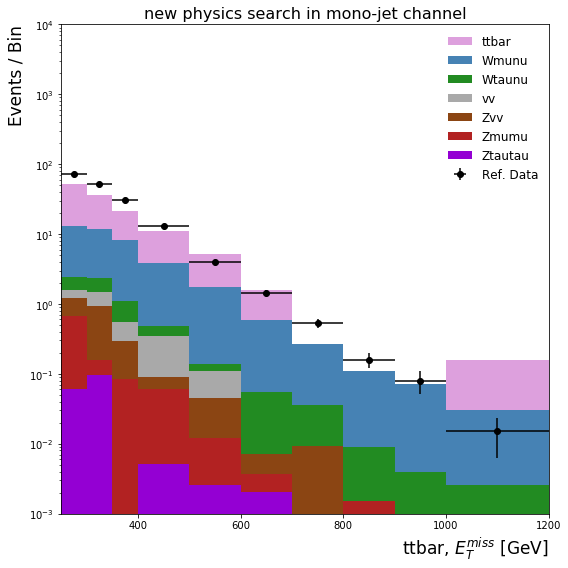

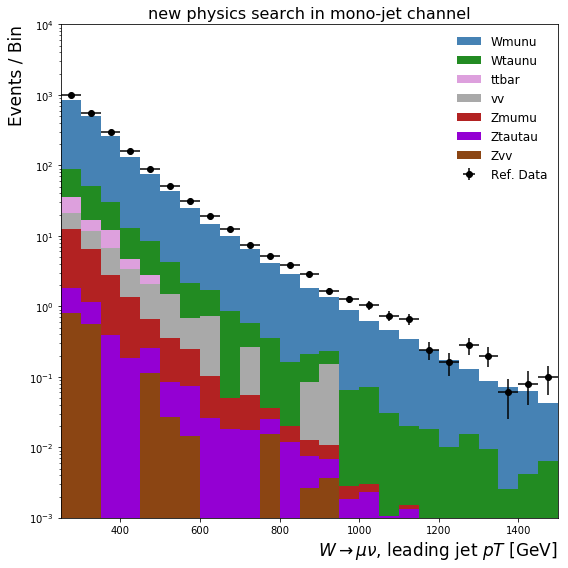

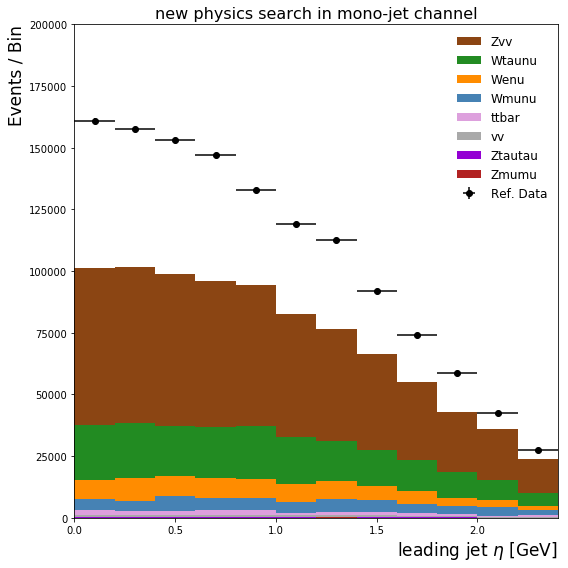

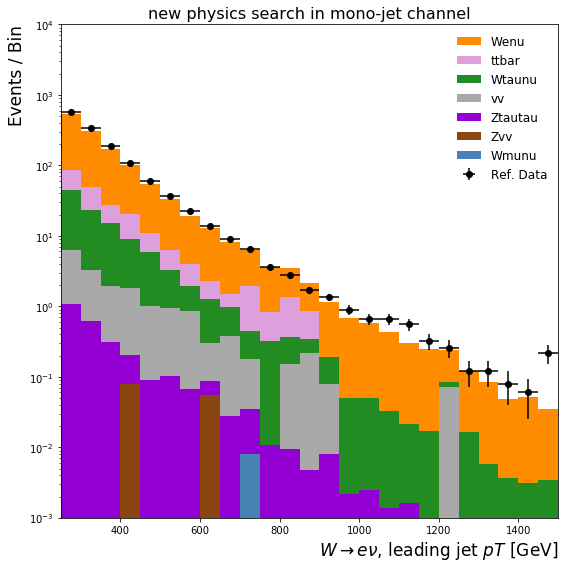

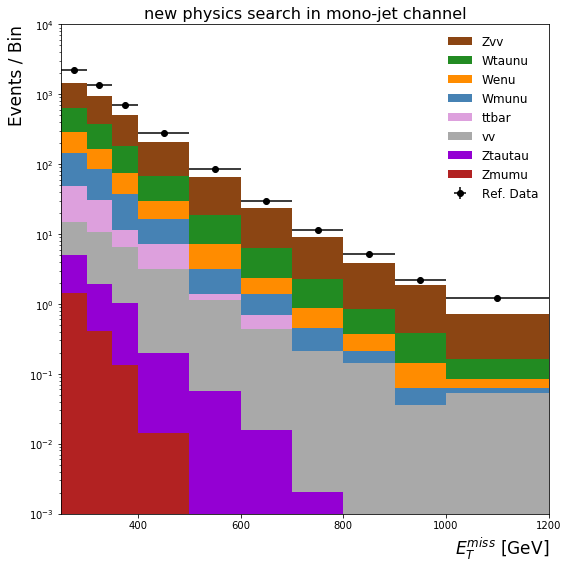

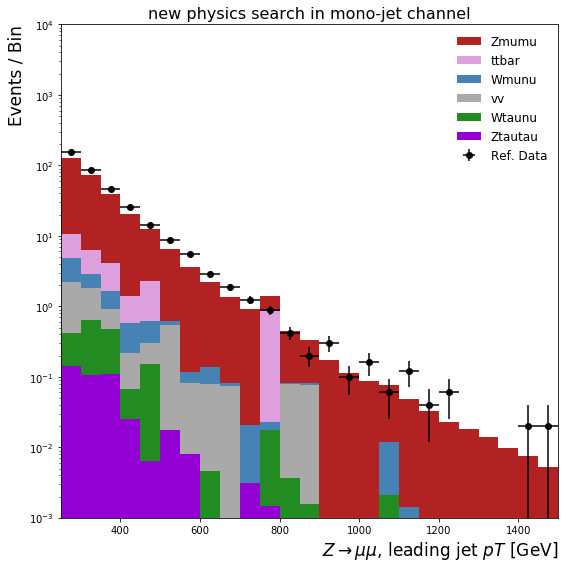

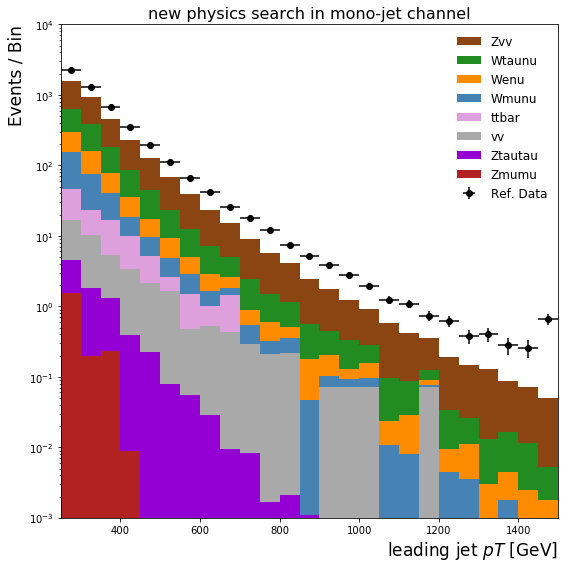

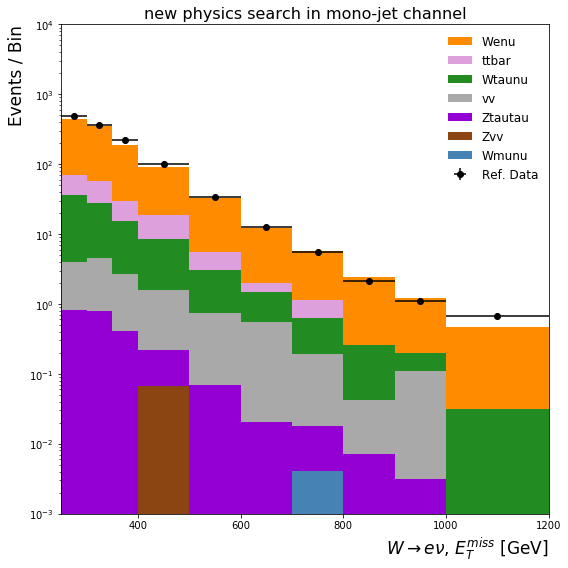

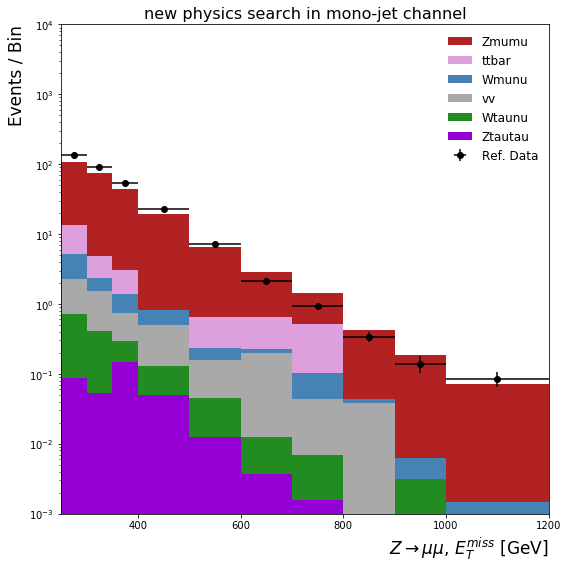

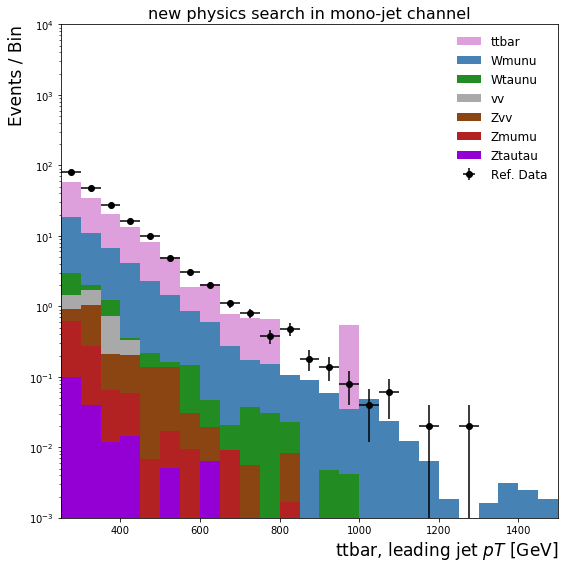

In [47]:

for name in iterkeys(xaxis_renames):
    logY = xaxis_renames[name][1]
    if logY:
        pp_stack(name, *(xaxis_renames[name]))
    elif "d12" in name:
        pp_stack(name, *(xaxis_renames[name]), y_limis=(0, 1.4e5))
    elif "d11" in name:
        pp_stack(name, *(xaxis_renames[name]), y_limis=(0, 2e5))
    else:
        pp_stack(name, *(xaxis_renames[name]), y_limis=(0, 4000))

In [67]:
pp_stack = make_ploter(input_dir, samples, analysis)

Wmunu yields: 10119.85
Wenu yields: 14945.94
Wtaunu yields: 38769.36
Zmumu yields: 100.198
Ztautau yields: 323.7025
Zvv yields: 105970.9
ttbar yields: 3339.225
vv yields: 1698.168
Total: 175267.3435
Data: 255486.0


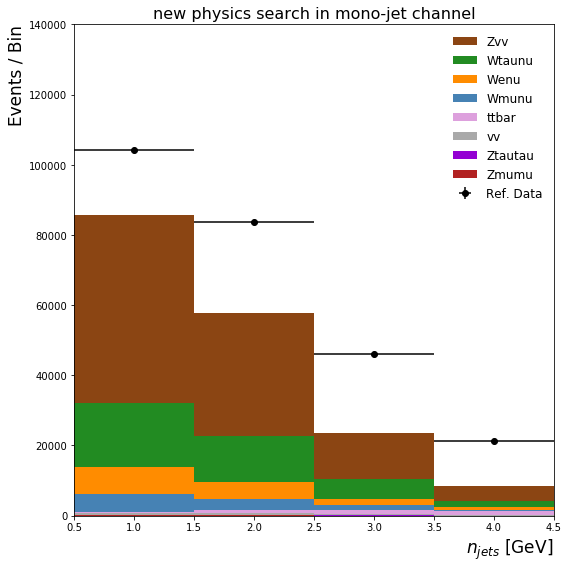

In [68]:
name = "d12-x01-y01"
pp_stack(name, *(xaxis_renames[name]), y_limis=(0, 1.4e5))

In [73]:
data_name = analysis+'.yoda'
input_ = os.path.join('inputs', input_dir)
ref_data = yoda.read(os.path.join(input_, data_name))

In [75]:
s2d = ref_data['/REF/'+analysis+"/d01-x01-y01"]

In [78]:
for p in s2d.points:
    print(p.y*(p.xMax-p.xMin))

44295.0
29458.0
16249.0
13859.0
4384.0
1543.0
629.0
258.0
130.0
133.0
